In [59]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import seaborn as sns

In [44]:
#creating a DF out of the entire csv
births_df = pd.read_csv("2021_Data.csv")
births_df.head()

,dob_yy,dob_mm,dob_tt,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,mager14,...,ca_downs,ca_disor,ca_hypo,f_ca_limb,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen
0,2021,1,636,1,1,1,NaN,NaN,22,8,...,N,N,N,1,1,1,1,1,1,1
1,2021,1,259,1,1,1,NaN,NaN,31,10,...,N,N,N,1,1,1,1,1,1,1
2,2021,1,223,1,1,1,NaN,NaN,29,9,...,N,N,N,1,1,1,1,1,1,1
3,2021,1,241,1,1,1,NaN,NaN,39,11,...,N,N,N,1,1,1,1,1,1,1
4,2021,1,503,1,1,1,NaN,NaN,20,8,...,N,N,N,1,1,1,1,1,1,1


# Data Cleaning: 

In [45]:
#choosing columns i want to examine more
clean_births_df = births_df[["dob_yy", "dob_mm","bfacil", "mager", "bmi_r", "priorlive", "priordead", "precare", "previs", "ld_anes", "attend","mm_aicu", "ab_nicu", "pay", "dbwt"]]
clean_births_df.head()

,dob_yy,dob_mm,bfacil,mager,bmi_r,priorlive,priordead,precare,previs,ld_anes,attend,mm_aicu,ab_nicu,pay,dbwt
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [46]:
#rename columns 
clean_births_df = clean_births_df.rename(columns={"dob_yy":"Birth Year", "dob_mm":"Birth Month", 
                                                  "bfacil":"Birth Place", "mager":"Mother's Age", "bmi_r":"Mother's BMI",
                                                  "priorlive":"Living Children", "priordead":"Deceased Children",
                                                 "precare": "Prenatal Care", "previs": "# of Prenatal Visits",
                                                  "ld_anes": "Used Anesthesia", "attend":"Attendant at Birth",
                                                  "mm_aicu":"Intensive Care Admission", "ab_nicu": "NICU Admission", 
                                                  "pay":"Payment Source", "dbwt":"Birth Weight",
                                                 })
clean_births_df.head()


,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
0,2021,1,1,22,2,0,0,3,99,Y,1,N,N,5,3670
1,2021,1,1,31,3,1,0,99,99,Y,1,N,N,6,3210
2,2021,1,1,29,2,1,0,3,8,N,3,N,N,2,3997
3,2021,1,1,39,2,0,0,2,10,Y,2,N,N,1,3510
4,2021,1,1,20,2,0,0,3,11,N,1,N,N,1,3100


In [47]:
#Filtering out any data that is unknown (this is represented by the values 9 and/or 99)
clean_births_df = clean_births_df[~clean_births_df.apply(lambda row: any(x in [9, 99] for x in row), axis=1)]

In [48]:
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                  int64
Mother's Age                 int64
Mother's BMI                 int64
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth           int64
Intensive Care Admission    object
NICU Admission              object
Payment Source               int64
Birth Weight                 int64
dtype: object

In [49]:
#declaring recoding responses as objects to later replace with coded meaning
clean_births_df = clean_births_df.astype({"Birth Place":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Mother's BMI":str}, errors='raise')
clean_births_df = clean_births_df.astype({"Attendant at Birth": str}, errors='raise')
clean_births_df = clean_births_df.astype({"Payment Source": str}, errors='raise')

In [50]:
#verify datatypes were changed
clean_births_df.dtypes

Birth Year                   int64
Birth Month                  int64
Birth Place                 object
Mother's Age                 int64
Mother's BMI                object
Living Children              int64
Deceased Children            int64
Prenatal Care                int64
# of Prenatal Visits         int64
Used Anesthesia             object
Attendant at Birth          object
Intensive Care Admission    object
NICU Admission              object
Payment Source              object
Birth Weight                 int64
dtype: object

In [51]:
#decoding inputs based on documentation

##For column: Birth place
clean_births_df["Birth Place"] = clean_births_df["Birth Place"].replace({"1":"Hospital", "2": "Freestanding Birth Center",
                                                                         "3":"Home (intended)", "4": "Home (unintended)",
                                                                        "5": "Home (intent unknown)", "6": "Clinic/Doctor's Office",
                                                                        "7":"Other",
                                                                        })
##For column: Mother's BMI
clean_births_df["Mother's BMI"] = clean_births_df["Mother's BMI"].replace({"1":"Underweight <18.5", "2":"Normal 18.5-24.9",
                                                                          "3": "Overweight 25.0-29.9", "4":"Obesity I 35.0-34.9",
                                                                          "5":"Obesity II 35.0-39.9", "6": "Extreme Obesity III ≥ 40.0",
                                                                          })
##For column: Prenatal Care
clean_births_df.loc[(clean_births_df['Prenatal Care'] >= 1) & (clean_births_df['Prenatal Care'] <= 10), 'Prenatal Care'] = 'Y'
clean_births_df.loc[(clean_births_df['Prenatal Care'] == 0), 'Prenatal Care'] = 'N'


##For column: Attendant at Birth
clean_births_df["Attendant at Birth"] = clean_births_df["Attendant at Birth"].replace({"1": "Doctor of Medicine (MD)", "2": "Doctor of Osteopathy (DO)",
                                                                                      "3":"Certified Nurse Midwife/Certified Midwife (CNM/CM)", "4":"Other Midwife",
                                                                                      "5": "Other",
                                                                                      })
##For column: Payment Source
clean_births_df["Payment Source"] = clean_births_df["Payment Source"].replace({"1":"Medicaid", "2":"Private Insurance",
                                                                              "3": "Self-Pay", "4":"Indian Health Service",
                                                                              "5":"CHAMPUS/TRICARE", "6":"Other Government (Federal, State, Local)",
                                                                              "8":"Other"})

#Show updated dataframe
clean_births_df.head()


C:\Users\esims\AppData\Local\Temp\ipykernel_8724\4228092671.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Y' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  clean_births_df.loc[(clean_births_df['Prenatal Care'] >= 1) & (clean_births_df['Prenatal Care'] <= 10), 'Prenatal Care'] = 'Y'


,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3997
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,3510
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,3100
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,3300
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,3495


In [52]:
#convert baby birth weight from grams to pounds

# Conversion factor from grams to pounds
grams_to_pounds_conversion_factor = 0.00220462

clean_births_df["Birth Weight"] = clean_births_df["Birth Weight"] * grams_to_pounds_conversion_factor

#Rename column 
clean_births_df = clean_births_df.rename(columns={"Birth Weight":"Birth Weight (lbs)"})

#display 
clean_births_df.head()

,Birth Year,Birth Month,Birth Place,Mother's Age,Mother's BMI,Living Children,Deceased Children,Prenatal Care,# of Prenatal Visits,Used Anesthesia,Attendant at Birth,Intensive Care Admission,NICU Admission,Payment Source,Birth Weight (lbs)
2,2021,1,Hospital,29,Normal 18.5-24.9,1,0,Y,8,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,8.811866
3,2021,1,Hospital,39,Normal 18.5-24.9,0,0,Y,10,Y,Doctor of Osteopathy (DO),N,N,Medicaid,7.738216
4,2021,1,Hospital,20,Normal 18.5-24.9,0,0,Y,11,N,Doctor of Medicine (MD),N,N,Medicaid,6.834322
5,2021,1,Hospital,29,Obesity II 35.0-39.9,0,0,Y,7,Y,Doctor of Medicine (MD),N,N,Private Insurance,7.275246
7,2021,1,Hospital,34,Normal 18.5-24.9,6,0,Y,11,N,Certified Nurse Midwife/Certified Midwife (CNM...,N,N,Private Insurance,7.705147


In [53]:
weight_df = clean_births_df[["Birth Weight (lbs)","Payment Source"]]
weight_df.head()

,Birth Weight (lbs),Payment Source
2,8.811866,Private Insurance
3,7.738216,Medicaid
4,6.834322,Medicaid
5,7.275246,Private Insurance
7,7.705147,Private Insurance


In [54]:
weight = weight_df["Birth Weight (lbs)"]
payment = weight_df["Payment Source"]

In [55]:
weight_df.tail()

,Birth Weight (lbs),Payment Source
99995,8.893437,Medicaid
99996,6.437490,Private Insurance
99997,6.338283,Medicaid
99998,8.234256,Private Insurance
99999,6.686612,Medicaid


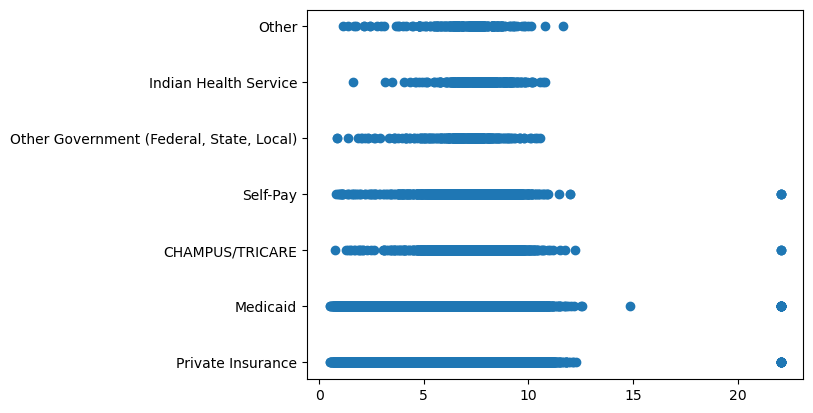

In [56]:
plt.scatter(weight, payment)

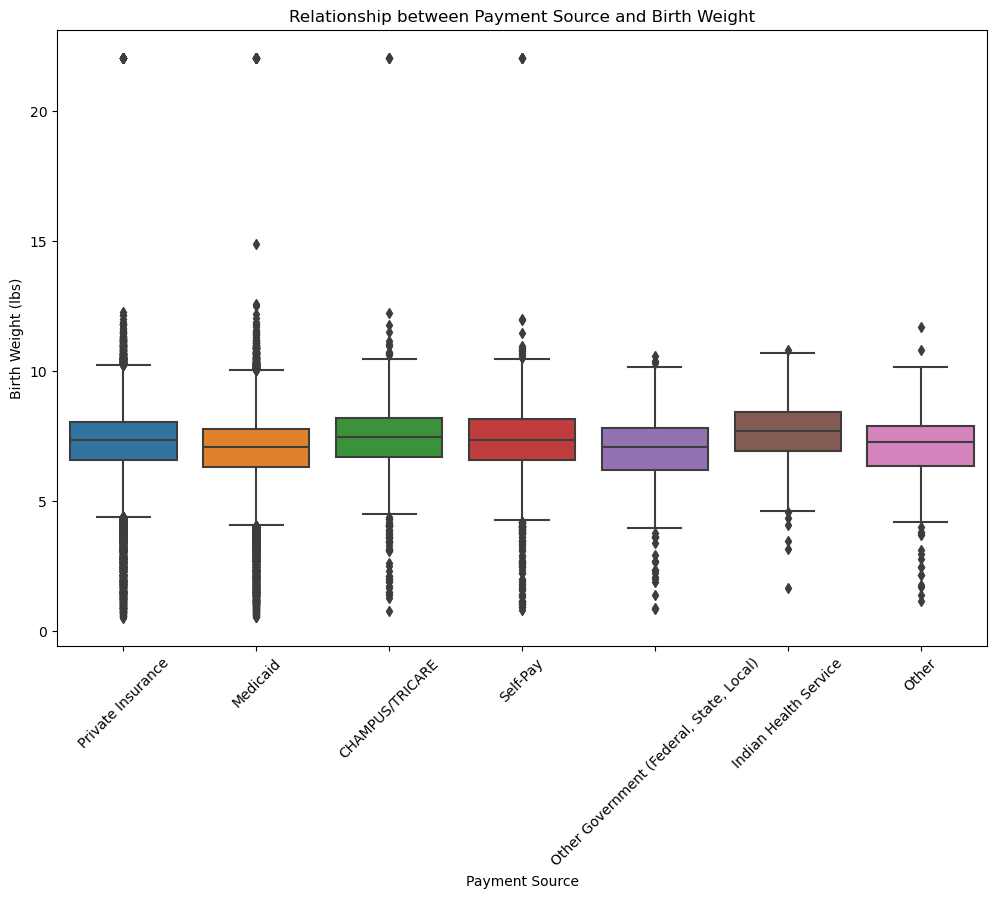

In [64]:
# Create a box plot or violin plot
plt.figure(figsize=(12, 8))
sns.boxplot(x='Payment Source', y='Birth Weight (lbs)', data=clean_births_df)
plt.title('Relationship between Payment Source and Birth Weight')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
# Save the figure
plt.savefig("weight_payment.png")
plt.show()

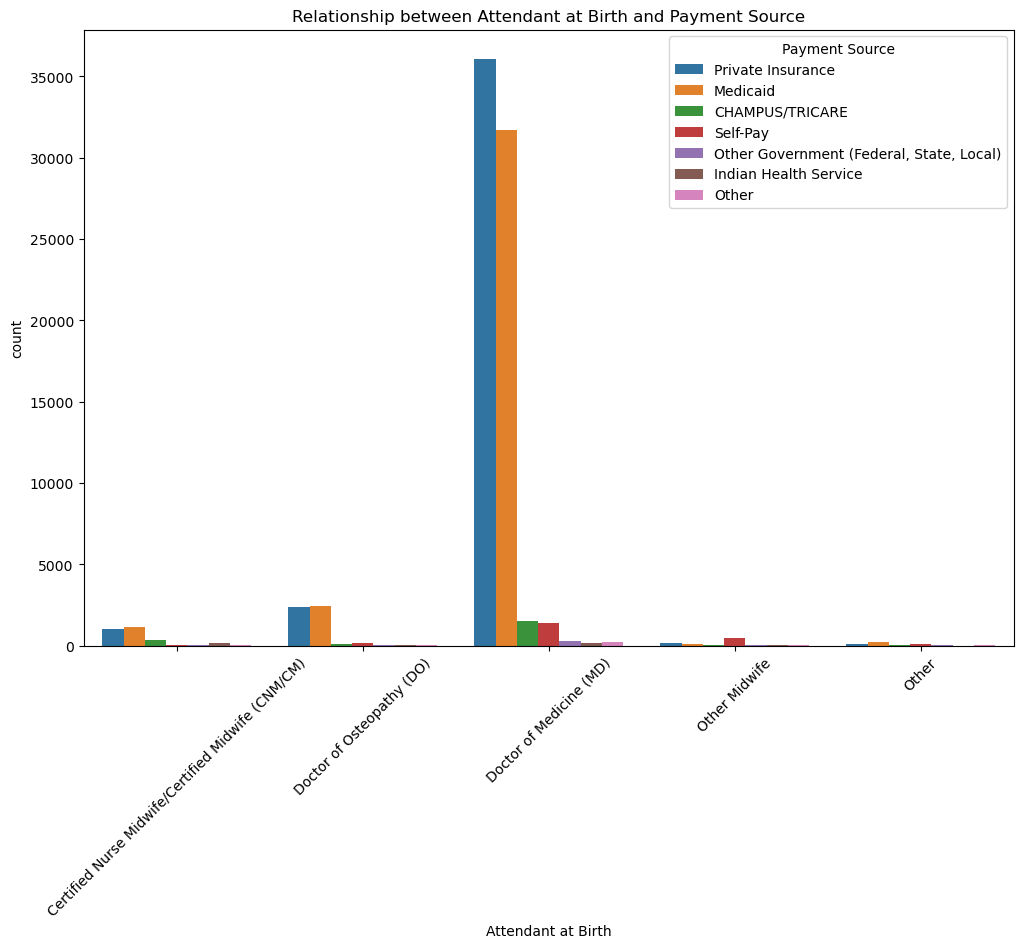

In [65]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Attendant at Birth', hue='Payment Source', data=clean_births_df)
plt.title('Relationship between Attendant at Birth and Payment Source')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend(title='Payment Source', bbox_to_anchor=(1, 1))  # Add legend for Payment Source
# Save the figure
plt.savefig("attending_payment.png")
plt.show()